# Nando CSPC 540

[website](http://www.cs.ubc.ca/~nando/540-2013/lectures.html)

[Youtube Lectures](https://www.youtube.com/playlist?list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6)

## Gaussian Process

Great way to do non-linear regression

[Video](https://www.youtube.com/watch?v=4vGiHC35j9s)

### Multivariate Gaussian PDF

Murphy p99, for a D-dimensions:

$$
\begin{aligned}
\mathcal{N}(x \mid \mu, \Sigma) &= \frac{1}{(2\pi)^{-D/2} \mid\Sigma\mid^{-1/2}}\exp\bigg[-\frac{1}{2}(y-\mu)^T\Sigma^{-1}(y-\mu)\bigg] \\
\mu &= \mathbb{E}(y) \\
\Sigma &= \mathbb{E}\big[(y-\mu)^T(y-\mu)\big] = \text{covariance} \\
\end{aligned}
$$


#### Marginal and Conditional Probabilities

See Murphy's book p113, Theorem 4.3.1. Proof in section 4.3.4.

* Vector dot products measure similarity

For covariance matrices:

$$
\begin{aligned}
std(x) = \sigma(x_1) = \sqrt{\mathbb{E}\big(x_1^2\big)} \\
covariance(x_1,x_2) = \mathbb{E}\big(x_1 x_2\big) \\
\end{aligned}
$$

For a 2-d joint Gaussian distributions, $X_1$ and $X_2$, the 1-d slice given $X_1 = x_1$ is:

$$ P(X_2 \mid X_1 = x_1)$$

If we have the data for the 2-d distribution, to arrive at the 1-d distrubtion, **read Chapter 4 Kevin Murphy's book on machine learning**. He provided the derivation. This allows you to go from the joint distribution to a single distribution.

### Sampling, how to sample from Gaussian

To sample an univariate Gaussian distributions, draw from a uniform distribution / random number generator, project onto a cumulative Gaussian probability function, and then project to a probability density function. Video / slides at 29:00.

This can generate a standard Gaussian of $\mathcal{N}(0, 1)$.

**Square root of matrices**: **Cholesky** decomposition of matrix $\Sigma$:
$$ \Sigma = LL^T $$

This allows us to sample multivariate Gaussian distributions. Using Multivariate Gaussian Theorem.

Covariances can be modelled as similarity, e.g. $K_{ij}$ is a value in the covariance matrix:

$$K_{ij} = \exp\big({-\left\Vert x_i - x_j \right\Vert^2}\big) $$

This is a Euclidean kernel.

## GP Basics

Data $D=\{(x_1, f_1),(x_2, f_2),(x_3, f_3)\}$

Given $x=(x_1, x_2, x_3)$, we want to model output $f=(f_1, f_2, f_3)$.

Example, model $f$ as $MVN(0, K)$, with elements of $K$ measuring distance/similarity. Think of these measures as **kernels**.

With new data $x_*$, goal is to predict $f_*$. 

**Then we use the MVN theorem 4.3.1 given in Murphy's book, p113.**, to derive $\mu_*$ and $\sigma_*$.

GP is a Gaussian distribution over functions. These functions themselves are not explicitly defined. Two functions needed:

* mean of x
* kernal for x, x'

$$
\begin{aligned}
f(x) \sim& GP(m(x), K(x,x')) \\
m(x) =& \mathbb{E}[f(x)] \\
K(x, x') =& \mathbb{E}\big[(f(x)-m(x))(f(x') - m(x'))^T\big]
\end{aligned}
$$

Draw samples:
1. create $x_{1:N}$
2. create $\mu=0_N$, $K$ of $N \times N$
3. $K=LL^T$
4. $f_i \sim N(0_N, K) \sim N(0, I) \times L$

## Noiseless GP Process

Using theorem 4.3.1 in Murphy's book, to make predictions for $f_*$:

$$
\begin{aligned}
\begin{pmatrix}
f\\
f_*
\end{pmatrix} 
\sim & \mathcal{N}\Bigg(
\begin{pmatrix}
\mu\\
\mu_*
\end{pmatrix} 
, 
\begin{pmatrix}
K & K_* \\
K_*^T & K_{**}
\end{pmatrix}
\Bigg)
\end{aligned}
$$

$$
\begin{aligned}
p(f_* \mid X_*,X,f) =& \mathcal{N}(f_*\mid \mu_*, \Sigma_*) \\
\mu_* =& \mu(X_*) + K^T_* K^{-1}(f-\mu(X)) \\
\Sigma_* =& K_{**}-K^T_*K^{-1}K_*
\end{aligned}
$$

This is essentially what the code does below.

## Example code:

With around 50 training points, the approximation becomes quite good.

In [1]:
#from __future__ import division
import numpy as np
import matplotlib.pyplot as pl

""" This is code for simple GP regression. It assumes a zero mean GP Prior """


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()


# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

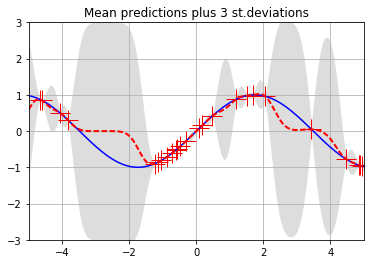

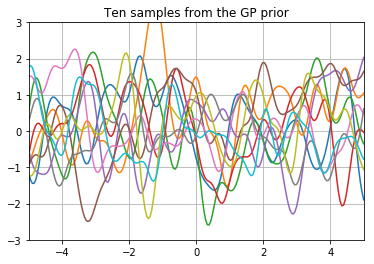

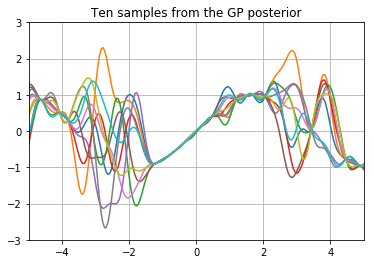

In [6]:
N = 25 # number of training points.
n = 200         # number of test points.
s = 0.00005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)


# PLOTS:
pl.figure(1)
pl.clf()
# plot true data points
pl.plot(X, y, 'r+', ms=20)
# plot prediction mean from test points
pl.plot(Xtest, f(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()

## Kernel Width

$$ K(x, x') = \sigma^2_f \exp\big(-\frac{1}{2l^2}(x-x')^2\big) $$

Use CV to choose $\mathcal{l}$ 

## Noisy GP Regression

$$
\begin{aligned}
y =& f(x) + \epsilon \text{, where } \epsilon \sim N(0, \sigma^2_y)\\
p(y\mid X) =& \int p(y \mid f, X) p(f \mid X)\,df\\
p(f \mid X) =& N(f \mid 0, K) \\
p(y \mid f) =& \Pi_{i} N(y_i \mid f_i, \sigma^2_y) \\
cov[y\mid X] =& K + \sigma^2_yI_N = K_y
\end{aligned}
$$

The rest is the same as noise-less GP, but replace $K$ with $K_y$.

Note that because of the noise variance, even for ares with data, the confidence internal won't collapse to zero.

# Other Videos

* [ref 1](https://www.youtube.com/watch?v=vU6AiEYED9E)

* [Alex Smola](https://www.youtube.com/watch?v=xP5dBw5cewg)

* [Neil Lawrence](https://www.youtube.com/watch?v=ewJ3AxKclOg)

* [Technical Uni. Munchen](https://www.youtube.com/watch?v=9hKfsuoFdeQ)

# [Fonnesbeck](https://blog.dominodatalab.com/fitting-gaussian-process-models-python/?utm_content=buffer211e8&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer)



In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Kernel function:

$$ k(x, x') = \theta_1 \exp\bigg( -\frac{\theta_2}{2}\big(x-x'\big)^2\bigg) $$

In [121]:
def exp_cov(x, y, params):
    return params[0] * np.exp(-.5 * params[1] * 
                              np.subtract.outer(x, y)**2)

Conditional multivariate Gaussian:

$$ p(x \mid y) = \mathbb(N)\big(\mu_x + \Sigma_{xy}\Sigma_{y}^{-1}(y - \mu_y), \Sigma_x - \Sigma_{xy}\Sigma_{y}^{-1}\Sigma_{xy}^T \big) $$

This is implemented in the function below:

In [104]:
def conditional(x_new, x, y, params):
    '''
    Assumption is mu_x and mu_y are both zero. See article for details.
    
    Calculates p(x_new | x)
    
    Parameters:
    x_new: 
        for Sigma_{x}
    x:
        for Sigma_{y}
    y:
        y in formula
    params:
        
        
    '''
    A = exp_cov(x_new, x_new, params) # \Sigma_x
    B = exp_cov(x_new, x, params) # \Sigma_{xy}
    C = exp_cov(x, x, params) # \Sigma_{y}
    
#     mu = np.linalg.inv(C).dot(B.T).T.dot(y) 
#     mu = (np.linalg.inv(C) @ B.T).T @ y
    mu = B @ np.linalg.inv(C).T @ y
    sigma = A - B @ np.linalg.inv(C) @ B.T
    return (mu.squeeze(), sigma.squeeze())

In [88]:
theta = [1, 10]
sigma_0 = exp_cov(0, 0, theta)
sigma_0

1.0

<Container object of 3 artists>

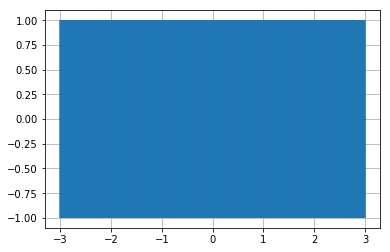

In [89]:
xpts = np.arange(-3, 3, step=.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)

In [123]:
def predict(i, data, kernel, params, sigma, y):
    k = [kernel(i, d, params) for d in data]
    sinv = np.linalg.inv(sigma)
    y_pred = k @ sinv @ y
    sigma_new = kernel(i, i, params) - k @ sinv @ k
    return y_pred, sigma_new

In [124]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
y

[-0.8089241014498411]

In [125]:
sigma_1 = exp_cov(x, x, theta)
sigma_1

array([[ 1.]])

In [126]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exp_cov, theta, sigma_1, y) for i in x_pred]
# predictions

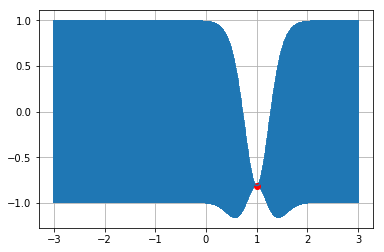

In [127]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, 'ro')

In [113]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
y

[-0.12171674240029494]

In [114]:
m, s = conditional([-.7], x, y, theta)
y2 = np.random.normal(m, s)
y2

1.8730581957749934

In [115]:
x.append(-.7)
y.append(y2)

In [116]:
sigma_2 = exp_cov(x, x, theta)
pred = [predict(i, x, exp_cov, theta, sigma_2, y) for i in x_pred]

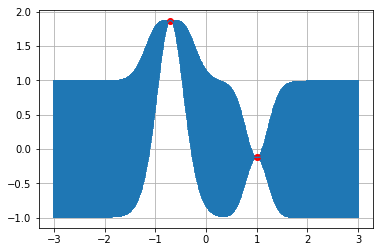

In [117]:
y_pred, sigmas = np.transpose(pred)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, 'ro')

In [118]:
x_more = [-2.1, -1.5, .3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, theta)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([ 1.77515882,  0.14305345,  0.29486297, -0.50843502,  0.94524229])

In [119]:
x += x_more
y += y_more.tolist()

sigma_new = exp_cov(x,x, theta)
pred = [predict(i, x, exp_cov, theta, sigma_new, y) for i in x_pred]

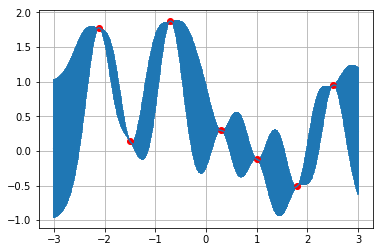

In [120]:
y_pred, sigmas = np.transpose(pred)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, 'ro')

In [103]:
np.min(sigmas)

-2.2204460492503131e-16